# Predicting House Prices

## Packages and Presets

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import plotnine as pn
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import (
    LabelEncoder,
    StandardScaler,
    OneHotEncoder,
    OrdinalEncoder,
    TargetEncoder,
    FunctionTransformer,
)
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin
from datetime import datetime, timedelta, date


# mizani formatters:
from mizani.formatters import comma_format, percent_format, currency_format
from tqdm.notebook import tqdm, trange
from skimpy import skim, clean_columns
import holidays
import missingno as msno
from pickle import dump, load

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.pipeline import FeatureUnion, make_pipeline, Pipeline
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import LassoCV

# outlier detection using isolation forest and pca
from sklearn.ensemble import IsolationForest
from pca import pca
import shap


from ydata_profiling import ProfileReport

from icecream import ic
import hydra


# sanest python user
import warnings
warnings.filterwarnings('ignore')

# set options for pandas
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 10)
pd.set_option('display.float_format', lambda x: '{:,.2f}'.format(x))

%load_ext blackcellmagic
%matplotlib inline

The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic


In [4]:
def custom_theme():
    return pn.theme_light() + \
           pn.theme(
               # Reduce chart junk
               panel_border=pn.element_blank(),
               panel_grid_major=pn.element_line(color='#eeeeee'),
               panel_grid_minor=pn.element_blank(),
               
               # Font settings for a cleaner look
               text=pn.element_text(size=10, color='black'),
               axis_title=pn.element_text(size=12, face='bold'),
               axis_text=pn.element_text(size=10),
               title=pn.element_text(size=14, face='bold', margin={'b': 20}),
               
               # Legend
               legend_background=pn.element_blank(),
               legend_position='right',
               legend_title=pn.element_text(face="bold"),
               legend_text=pn.element_text(size=10),
               
               # Figure properties
               figure_size=(10,6)
           )
pn.theme_set(custom_theme())

In [40]:
# read in conf/config.yml file using hydra:
from omegaconf import DictConfig, OmegaConf
config_path = "conf/config.yml"

cfg = OmegaConf.load(config_path)

{'data': {'input': 'data/data.csv'}, 'catboost': {'iterations': 1000, 'learning_rate': 0.05, 'depth': 6, 'loss_function': 'RMSE', 'verbose': 0, 'random_state': 42}}


## Loading Data

In [41]:
data = (
    pd.read_csv(cfg.data.input, parse_dates=['date']).
    pipe(clean_columns)
)
print(data.shape)
print(data.columns)

(4600, 18)
Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'street', 'city',
       'statezip', 'country'],
      dtype='object')


In [6]:
skim(data)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 4600   │ │ int64       │ 9     │                                                          │
│ │ Number of columns │ 18     │ │ float64     │ 4     │                                                          │
│ └───────────────────┴────────┘ │ string      │ 4     │                                                          │
│                                │ datetime64  │ 1     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━┳━━━━━┳━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name     ┃ NA  ┃ NA %  ┃ mean    ┃ sd      ┃ p0    ┃ p25     ┃ p50     ┃ p75    ┃ p100     ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━━━╇━━━━━╇━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━┩  │
│ │ price           │   0 │     0 │  550000 │  560000 │     0 │  320000 │  460000 │ 650000 │ 27000000 │   ▇    │  │
│ │ bedrooms        │   0 │     0 │     3.4 │    0.91 │     0 │       3 │       3 │      4 │        9 │   ▁▇▁  │  │
│ │ bathrooms       │   0 │     0 │     2.2 │    0.78 │     0 │     1.8 │     2.2 │    2.5 │        8 │  ▂▇▂   │  │
│ │ sqft_living     │   0 │     0 │    2100 │     960 │   370 │    1500 │    2000 │   2600 │    14000 │   ▇▃   │  │
│ │ sqft_lot        │   0 │     0 │   15000 │   36000 │   640 │    5000 │    7700 │  11000 │  1100000 │   ▇    │  │
│ │ floors          │   0 │     0 │     1.5 │    0.54 │     1 │       1 │     1.5 │      2 │      3.5 │  ▇▂▇   │  │
│ │ waterfront      │   0 │     0 │  0.0072 │   0.084 │     0 │       0 │       0 │      0 │        1 │   ▇    │  │
│ │ view            │   0 │     0 │    0.24 │    0.78 │     0 │       0 │       0 │      0 │        4 │   ▇    │  │
│ │ condition       │   0 │     0 │     3.5 │    0.68 │     1 │       3 │       3 │      4 │        5 │    ▇▃▁ │  │
│ │ sqft_above      │   0 │     0 │    1800 │     860 │   370 │    1200 │    1600 │   2300 │     9400 │  ▇▅▁   │  │
│ │ sqft_basement   │   0 │     0 │     310 │     460 │     0 │       0 │       0 │    610 │     4800 │   ▇▂   │  │
│ │ yr_built        │   0 │     0 │    2000 │      30 │  1900 │    2000 │    2000 │   2000 │     2000 │ ▂▂▅▆▇▇ │  │
│ │ yr_renovated    │   0 │     0 │     810 │     980 │     0 │       0 │       0 │   2000 │     2000 │ ▇    ▅ │  │
│ └─────────────────┴─────┴───────┴─────────┴─────────┴───────┴─────────┴─────────┴────────┴──────────┴────────┘  │
│                                                    datetime                                                     │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name            ┃ NA     ┃ NA %      ┃ first               ┃ last                ┃ frequency        ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩  │
│ │ date                   │      0 │         0 │     2014-05-02      │     2014-07-10      │ None             │  │
│ └────────────────────────┴────────┴───────────┴─────────────────────┴─────────────────────┴──────────────────┘  │
│                                                     st

In [7]:
data = (
    data.assign(
        hour=lambda x: x.date.dt.hour + 1,
        day=lambda x: x.date.dt.day,
        weekday = lambda x: x.date.dt.day_name(),
        month= lambda x: x.date.dt.month_name(),
        year = lambda x: x.date.dt.year,
        weekend = lambda x: np.where(
            x.weekday.isin(['Sunday', 'Saturday']), 1, 0
        ),
        work_hour=lambda x: np.where(
            x.hour.isin([8,9,10,11,12,13,14,15,16,17,18]),1,0
        ),
        week_hour=lambda x: x.date.dt.dayofweek * 24 + (x.hour + 1)
    )
)


ic(data.year.nunique(), data.month.nunique(), data.day.nunique())

ic| data.year.nunique(): 1
    data.month.nunique(): 3
    data.day.nunique(): 31


(1, 3, 31)

## EDA

ic| data.groupby('weekday').size():

 weekday
                                    Friday        718
                                    Monday        826
                                    Saturday       66
                                    Sunday         65
                                    Thursday      848
                                    Tuesday      1067
                                    Wednesday    1010
                                    dtype: int64


Text(0.5, 1.0, 'Sum of prices per weekday')

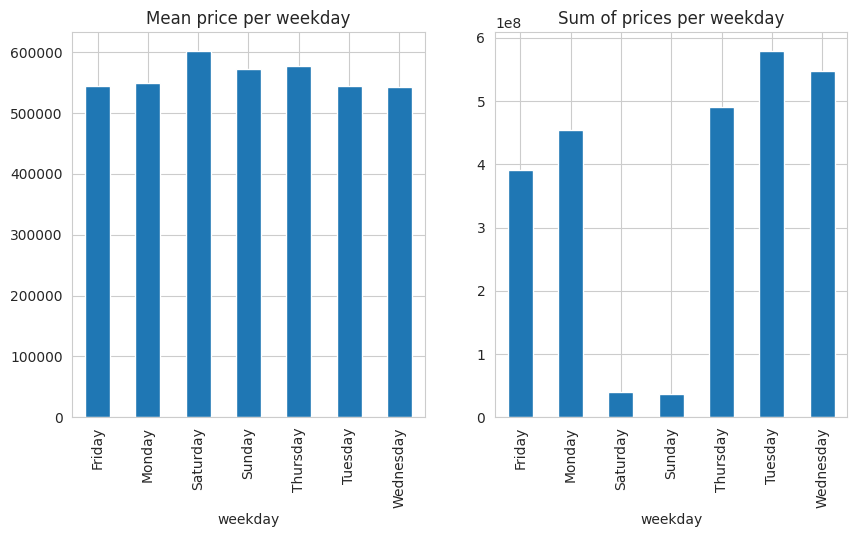

In [8]:
ic(data.groupby('weekday').size())
fig, ax = plt.subplots(1, 2, figsize=(10,5))
axs = ax.flatten()
data.groupby('weekday').price.mean().plot(kind='bar', ax=axs[0])
data.groupby('weekday').price.sum().plot(kind='bar', ax=axs[1])
axs[0].set_title('Mean price per weekday')
axs[1].set_title('Sum of prices per weekday')

ic| data.groupby('month

').size(): month
                                  July     653
                                  June    2179
                                  May     1768
                                  dtype: int64


Text(0.5, 1.0, 'Sum of prices per month')

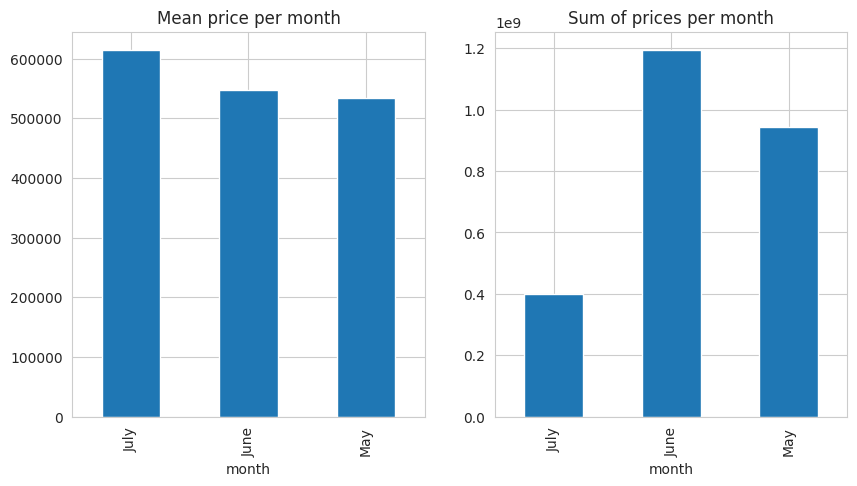

In [9]:
ic(data.groupby('month').size())
fig, ax = plt.subplots(1, 2, figsize=(10,5))
axs = ax.flatten()
data.groupby('month').price.mean().plot(kind='bar', ax=axs[0])
data.groupby('month').price.sum().plot(kind='bar', ax=axs[1])
axs[0].set_title('Mean price per month')
axs[1].set_title('Sum of prices per month')

In [10]:
data.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country,hour,day,weekday,month,year,weekend,work_hour,week_hour
0,2014-05-02,"313,000.00",3.00,1.50,1340,7912,1.50,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA,1,2,Friday,May,2014,0,0,98
1,2014-05-02,"2,384,000.00",5.00,2.50,3650,9050,2.00,0,4,5,3370,280,1921,0,709 W Blaine St,Seattle,WA 98119,USA,1,2,Friday,May,2014,0,0,98
2,2014-05-02,"342,000.00",3.00,2.00,1930,11947,1.00,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA,1,2,Friday,May,2014,0,0,98
3,2014-05-02,"420,000.00",3.00,2.25,2000,8030,1.00,0,0,4,1000,1000,1963,0,857 170th Pl NE,Bellevue,WA 98008,USA,1,2,Friday,May,2014,0,0,98
4,2014-05-02,"550,000.00",4.00,2.50,1940,10500,1.00,0,0,4,1140,800,1976,1992,9105 170th Ave NE,Redmond,WA 98052,USA,1,2,Friday,May,2014,0,0,98


In [11]:
data.price.mean()

551962.9884732141

(-2.0, 5.0)

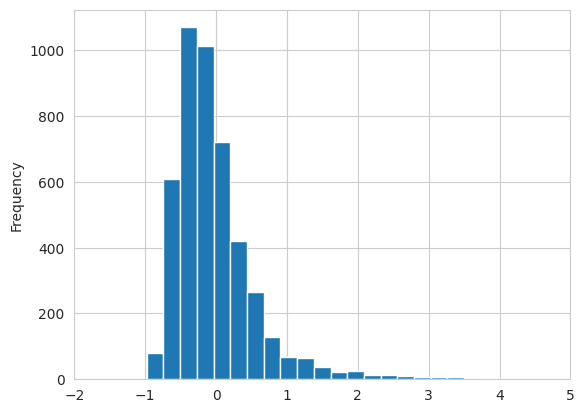

In [12]:
data.price.map(
    lambda x: (x - data.price.mean())/data.price.std()
).plot.hist(bins=200)
plt.xlim(-2, 5)


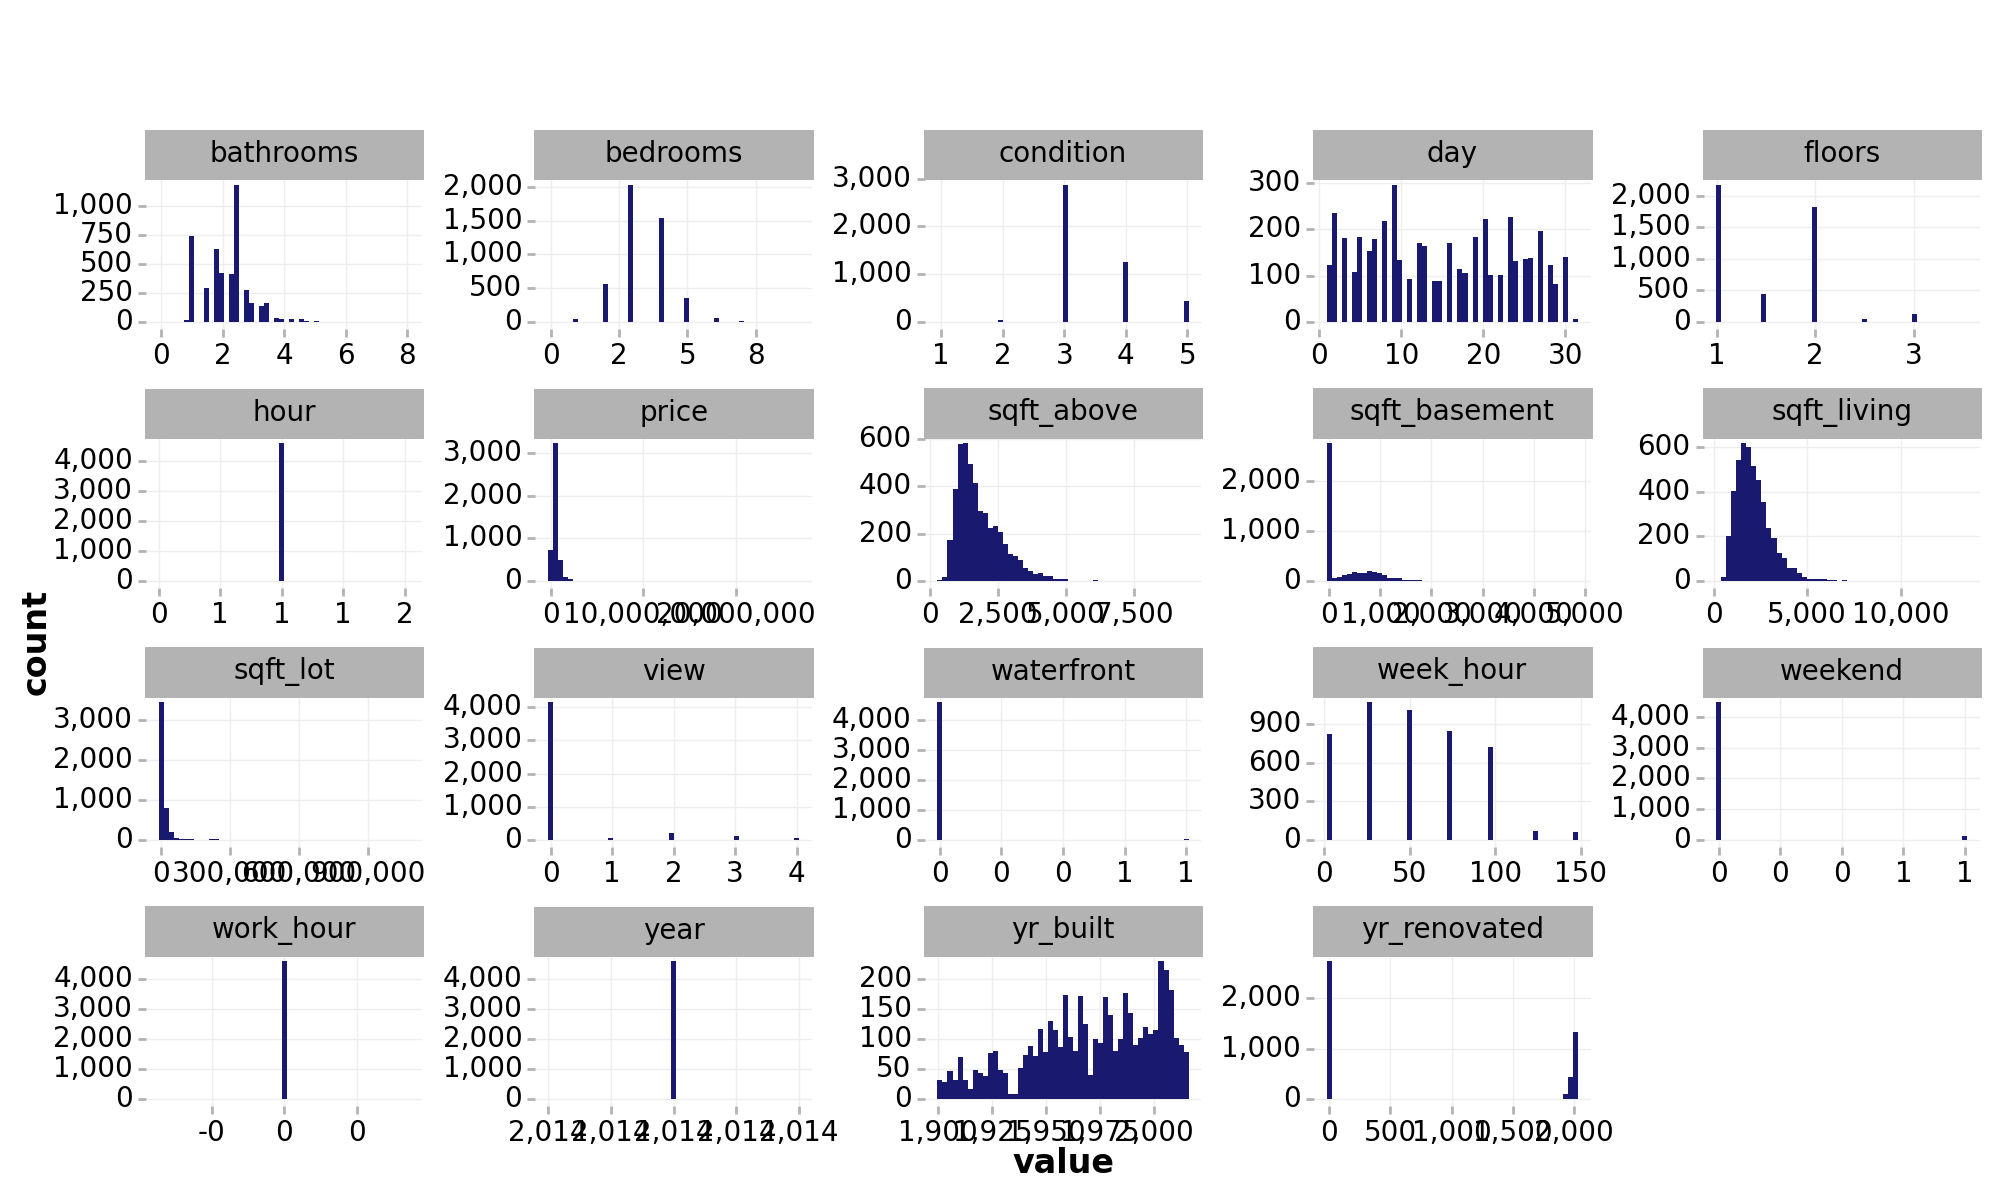

<Figure Size: (1000 x 600)>

In [13]:
(
    pn.ggplot(data=data.select_dtypes(include="number").melt(), mapping=pn.aes(x="value"))
    + pn.geom_histogram(bins=50, fill="midnightblue")
    + pn.facet_wrap("~ variable", scales="free")
    + pn.scale_x_continuous(labels=comma_format())
    + pn.scale_y_continuous(labels=comma_format())
)

In [14]:
(
    data.groupby(['statezip','yr_built']).
    price.agg(['mean', 'count']).
    reset_index().
    sort_values('mean', ascending=False).
    head(10)
)

,statezip,yr_built,mean,count
2411,WA 98199,1956,"12,899,000.00",1
98,WA 98004,1940,"7,062,500.00",1
562,WA 98031,1992,"6,851,487.50",4
753,WA 98040,1983,"4,668,000.00",1
133,WA 98004,2001,"4,489,000.00",1
721,WA 98039,2000,"3,710,000.00",1
760,WA 98040,1999,"3,100,000.00",1
667,WA 98034,1989,"3,000,000.00",1
2288,WA 98177,1965,"2,888,000.00",1
714,WA 98039,1952,"2,750,000.00",1


In [15]:
profile = ProfileReport(data, title="Pandas Profiling Report", explorative=True)
# save to html file
profile.to_file("eda_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## Preprocessing

In [16]:

X = data.drop(columns=["price", "date"])
y = data.price
X = X.query('@y > 0')
y = y.loc[X.index]

cat_features_small = [col for col in X.columns if X[col].nunique() < 10]
cat_features_big = [
    col for col in X.columns 
    if X[col].nunique() >= 10 and X[col].dtype == 'object'
]
num_features = [
    col for col in X.columns
    if col not in cat_features_small + cat_features_big
]

In [17]:

num_trans = Pipeline(
    steps=[
        (
            "scaler", StandardScaler()
        )
    ]
)

tree_small_cat_trans = Pipeline(
    steps=[
        (
            "encoder",
            OrdinalEncoder(handle_unknown="error"),
        ),
    ]
)

non_tree_small_cat_trans = Pipeline(
    steps=[
        (
            "encoder",
            OneHotEncoder(handle_unknown="error"),
        ),
    ]
)


big_cat_trans = Pipeline(
    steps=[
        (
            "encoder",
            TargetEncoder(random_state=42, target_type="continuous"),
        ),
    ]
)


tree_preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", num_trans, num_features),
        ("categorical_small", tree_small_cat_trans, cat_features_small),
        ("categorical_big", big_cat_trans, cat_features_big)
    ]
)


non_tree_preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", num_trans, num_features),
        ("categorical_small", non_tree_small_cat_trans, cat_features_small),
        ("categorical_big", big_cat_trans, cat_features_big)
    ]
)

X_tree = tree_preprocessor.fit_transform(X, y)
X_non_tree = non_tree_preprocessor.fit_transform(X, y)

Text(0, 0.5, 'Normalized Mutual Information')

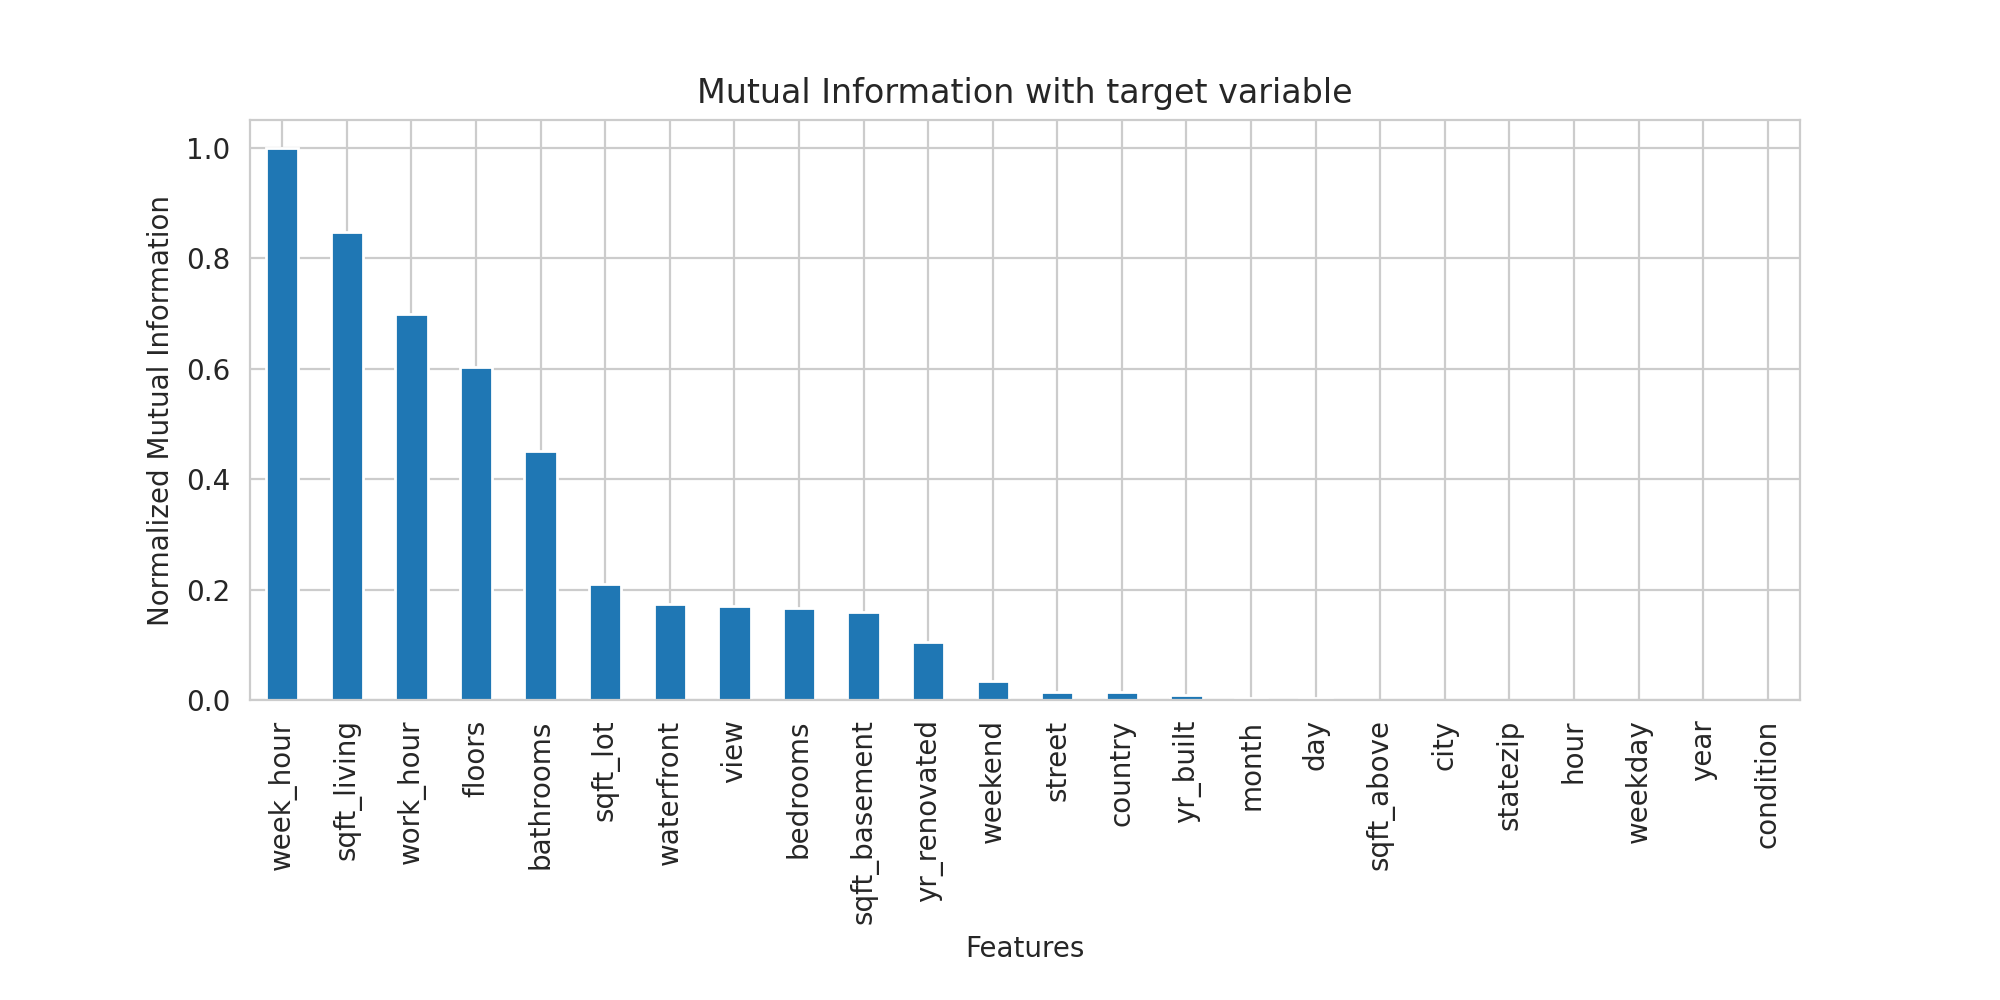

In [18]:
# mutual information
mi = mutual_info_regression(X_tree, y)

# plot mutual info using sns
mi = pd.Series(mi, index=X.columns)
mi = mi.sort_values(ascending=False)
mi = mi / mi.max()

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
# add whitespace below x axis
plt.subplots_adjust(bottom=0.3)
mi.plot.bar(ax=ax)
ax.set_title("Mutual Information with target variable")
ax.set_xlabel("Features")
ax.set_ylabel("Normalized Mutual Information")

In [19]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(
    X_non_tree, y.to_numpy(), test_size=0.2, random_state=42
)

# iso = IsolationForest(contamination=0.01)
# outliers = iso.fit_predict(X_train)==-1
# X_train = X_train[~outliers]
# y_train = y_train[~outliers]

# outlier detection using pca
# pca_model =  pca(normalize=True, detect_outliers=['ht2', 'spe'], n_std=3)
# results = pca_model.fit_transform(X_train)
# outliers = np.where(~results['outliers']['y_bool'])[0]
# X_train = X_train[outliers]
# y_train = y_train[outliers]


# lassso cv regression with R2 as scoring
lasso = LassoCV(n_alphas=1_000,cv=5, random_state=42, n_jobs=-1)
lasso.fit(X_train, np.log(y_train))
y_pred = np.exp(lasso.predict(X_test))

print(r2_score(y_test, y_pred))
#mse
print(mean_squared_error(y_test, y_pred))
#mae
print(mean_absolute_error(y_test, y_pred))

0.2778754206821482
107430755791.17361
182442.30127047753


In [20]:
# xgboost regression
X_train, X_test, y_train, y_test = train_test_split(
    X_tree, y.to_numpy(), test_size=0.2, random_state=42
)

iso = IsolationForest(contamination=0.01)
outliers = iso.fit_predict(X_train)==-1
X_train = X_train[~outliers]
y_train = y_train[~outliers]

# # outlier detection using pca
# pca_model =  pca(normalize=True, detect_outliers=['ht2', 'spe'], n_std=3)
# results = pca_model.fit_transform(X_train)
# outliers = np.where(~results['outliers']['y_bool'])[0]
# X_train = X_train[outliers]
# y_train = y_train[outliers]

xgb = XGBRegressor(n_jobs=-1, random_state=42)
xgb.fit(X_train,np.log(y_train))
y_pred = np.exp(xgb.predict(X_test))

print(r2_score(y_test, y_pred))
#mse
print(mean_squared_error(y_test, y_pred))

# mae
print(mean_absolute_error(y_test, y_pred))

0.6611292962866262
50413926984.46073
105061.30243198956


0.7244367693558428
40995649482.42644
97399.33795455637


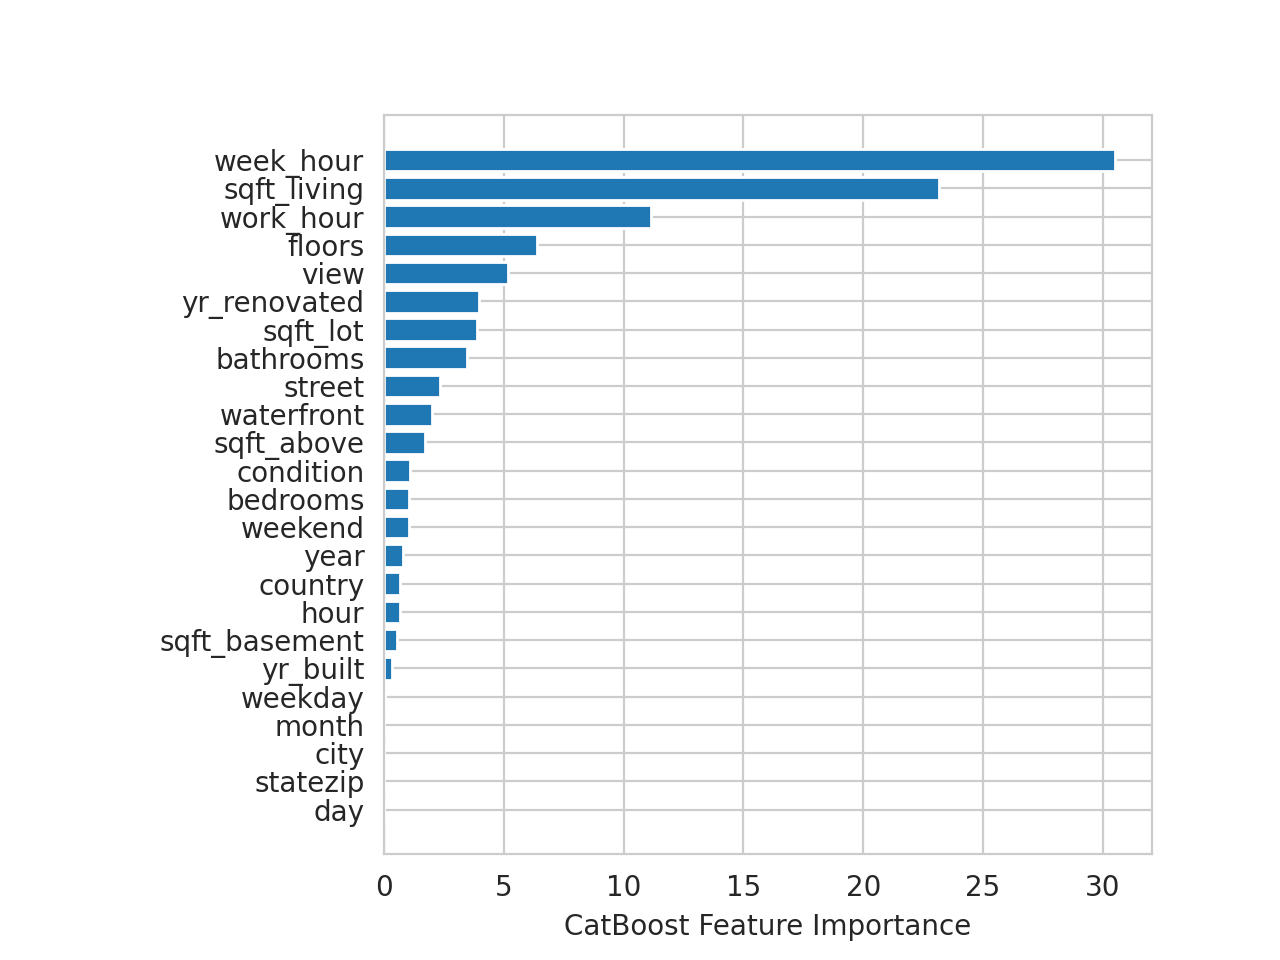

In [42]:
# using catboost
X_train, X_test, y_train, y_test = train_test_split(
    X_tree, y.to_numpy(), test_size=0.2, random_state=42
)

# iso = IsolationForest(contamination=0.01, random_state = 42)
# outliers = iso.fit_predict(X_train)==-1
# X_train = X_train[~outliers]
# y_train = y_train[~outliers]


cat = CatBoostRegressor(
    iterations=cfg.catboost.iterations,
    learning_rate=cfg.catboost.learning_rate,
    depth=cfg.catboost.depth,
    loss_function=cfg.catboost.loss_function,
    random_state=cfg.catboost.random_state,
    verbose=cfg.catboost.verbose
)
cat.fit(X_train, np.log(y_train))
y_pred = np.exp(cat.predict(X_test))

print(r2_score(y_test, y_pred))
#mse
print(mean_squared_error(y_test, y_pred))
#mae
print(mean_absolute_error(y_test, y_pred))

# plot feature importance
feature_importance = cat.get_feature_importance()
feature_names = np.array(X.columns)#cat.feature_names_)
sorted_idx = np.argsort(feature_importance)
plt.barh(feature_names[sorted_idx], feature_importance[sorted_idx])
plt.xlabel("CatBoost Feature Importance")
plt.subplots_adjust(left=0.3)
plt.show()

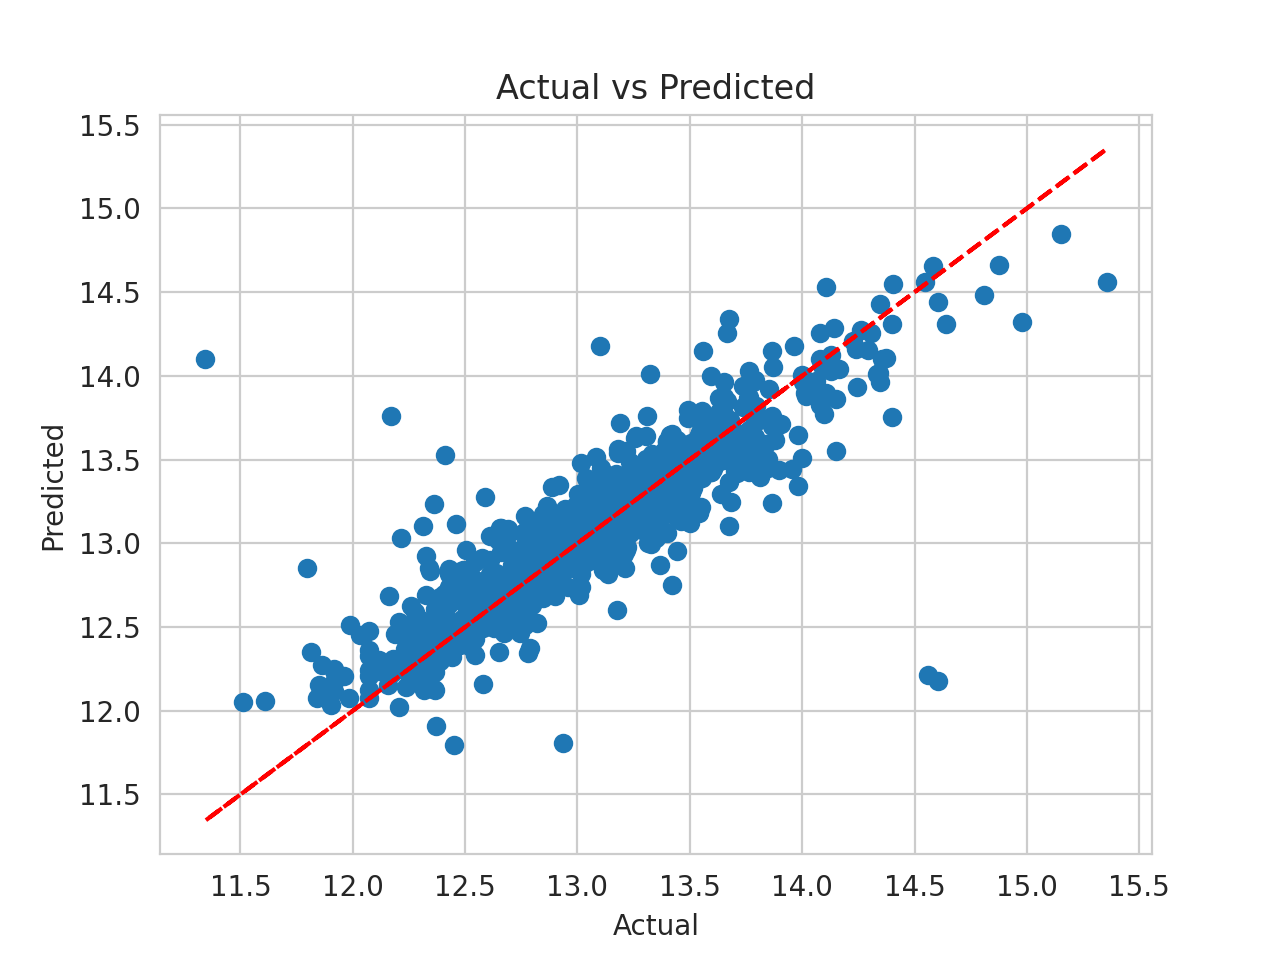

In [22]:
# plot prediction vs actual
plt.scatter(np.log(y_test), np.log(y_pred))
# line through the origin
plt.plot(np.log(y_test), np.log(y_test),'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")
plt.show()

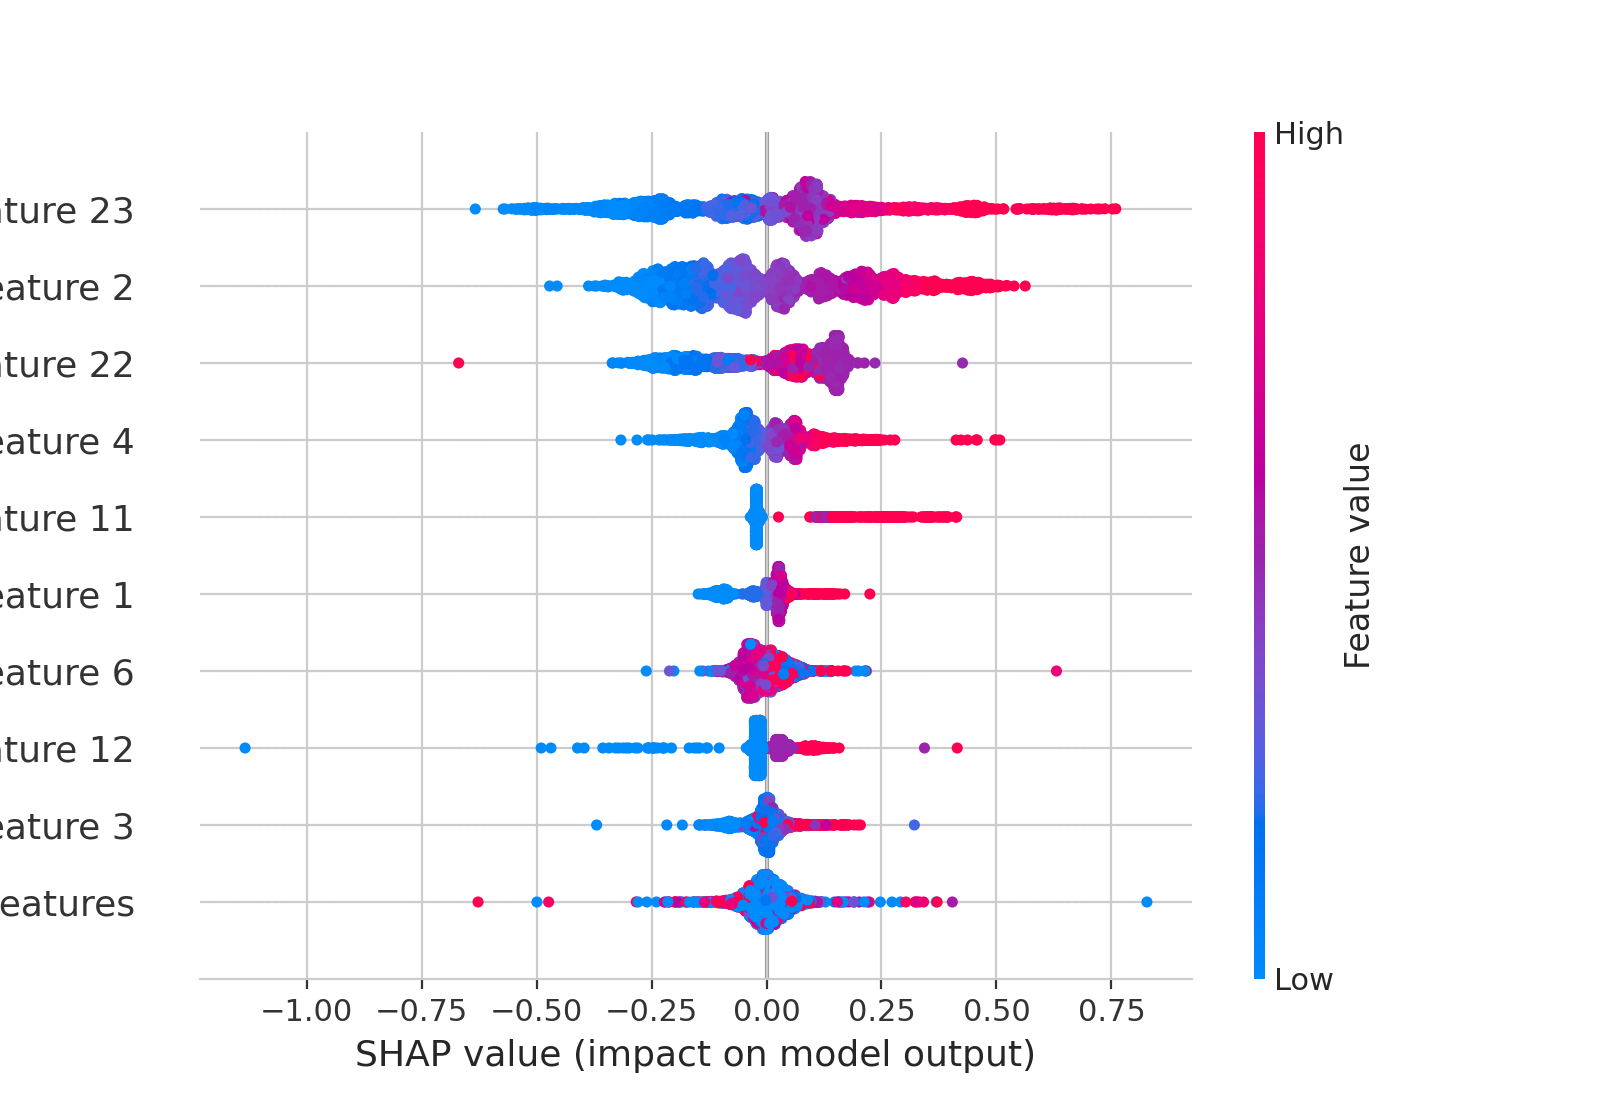

<Figure size 640x480 with 0 Axes>

In [23]:
# apply shap values to catboost
explainer = shap.TreeExplainer(cat)
shap_values = explainer(X_train)
shap.plots.beeswarm(shap_values, max_display=10)
plt.subplots_adjust(left=0.5)